In [1]:
import numpy as np
import cvxpy as cp

from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.utils.data as Data
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
from models.LISTA import LISTA_Net
from models.L20_ISTA import L2O_ISTA
from models.TiLISTA import TiLISTA
from models.ALISTA import ALISTA

from utils.ISTA_FISTA import *
from utils.train import train
from utils.synthetic_data import SyntheticSignals

In [3]:
torch.cuda.is_available()

True

# Learned Iterative Soft Thresholding Algorithm (LISTA)

In [4]:
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.02

# Sensing matrix

A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
A_ /= torch.linalg.norm(A_, dim = 0)

# Building a training set and a test set 
train_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 4000
    ).set_loader()

test_set = SyntheticSignals(
    A = A_,
    n = n_,        
    m = m_,
    p = p_,
    SNR = 100,
    size = 1000
    ).set_loader()

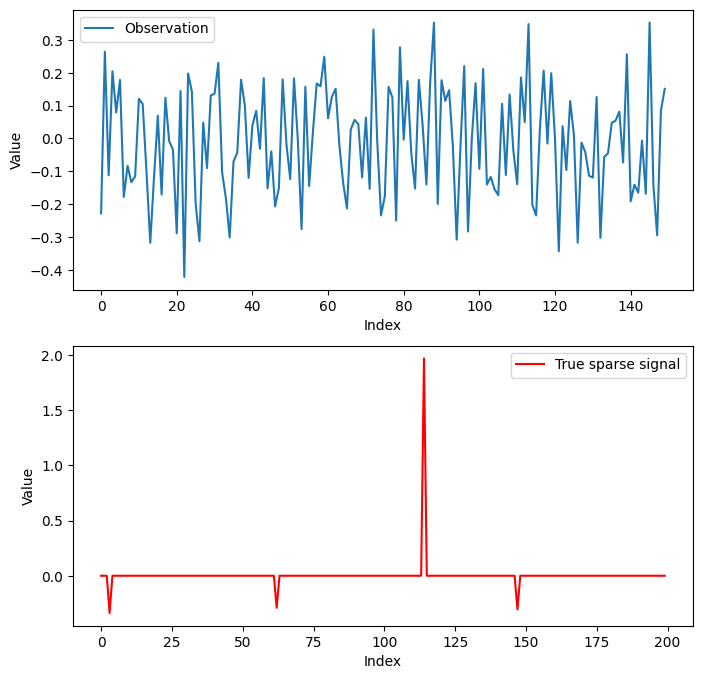

In [5]:
x_exm, s_exm =test_set.dataset.__getitem__(20)
plt.figure(figsize=(8, 8)) 
plt.subplot(2, 1, 1) 
plt.plot(x_exm, label = 'Observation' ) 
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend( )
plt.subplot (2, 1, 2) 
plt.plot(s_exm, label = 'True sparse signal', color='r')  
plt.xlabel('Index', fontsize=10)
plt.ylabel('Value', fontsize=10)
plt.legend()
plt.show()

### Comparing ISTA and LISTA

In [6]:
model = LISTA_Net(torch.clone(A_), 0.4, 5)
loss = train(model, train_set, test_set, num_epochs=50, verbose = True)

Epoch 0, Train NMSE (dB) -12.16089727, Validation NMSE (dB) -15.88758359
Epoch 10, Train NMSE (dB) -24.16470188, Validation NMSE (dB) -21.53892769
Epoch 20, Train NMSE (dB) -25.42985346, Validation NMSE (dB) -20.96768830
Epoch 30, Train NMSE (dB) -26.67033866, Validation NMSE (dB) -21.62496497
Epoch 40, Train NMSE (dB) -26.79910913, Validation NMSE (dB) -21.94984552


In [13]:
M = 50
LAYERS = 5
# Dimensions for the signal, its sparsity and its observation

n_ = 200
m_ = 150
p_ = 0.02

ISTA_LOSS = np.zeros((M, 100))
FISTA_LOSS = np.zeros((M, 100))
LISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 100,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = 100,
        size = 1000
        ).set_loader()
    
    model = LISTA_Net(torch.clone(A_), 0.4, 5)
    loss = train(model, train_set, test_set, num_epochs=50, verbose = False)
    
    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, 100, A_, rho = 0.4)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, 100, A_, rho = 0.4)
    LISTA_LOSS[m,:] = model.compute_nmse_inference(test_set)

100%|██████████| 50/50 [42:41<00:00, 51.22s/it]


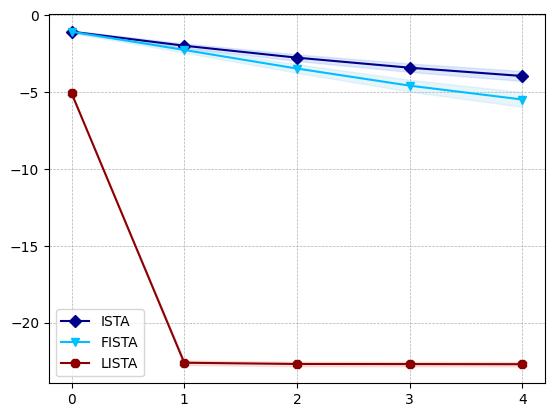

In [16]:
plt.plot(np.mean(ISTA_LOSS, axis = 0)[0:LAYERS], label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(ISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0)[0:LAYERS], 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0)[0:LAYERS], label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                np.mean(FISTA_LOSS, axis = 0)[0:LAYERS] + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0)[0:LAYERS], 
                color='skyblue', 
                alpha=0.2)

plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='lightcoral', 
                    alpha=0.2)
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()

# ALISTA - Linear transformation is computed analitically

### LISTA vs ALISTA vs TILISTA - Fight!

### Noiseless case

In [4]:
M = 50
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = None

LISTA_LOSS = torch.zeros((M, LAYERS))
ALISTA_LOSS = torch.zeros((M, LAYERS))
TiLISTA_LOSS = torch.zeros((M, LAYERS))
L2O_ISTA_LOSS = torch.zeros((M, LAYERS))
ISTA_LOSS = torch.zeros((M, LAYERS))
FISTA_LOSS = torch.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=True)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=True)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=True)

    model4 = L2O_ISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=True)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    ALISTA_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    TiLISTA_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    L2O_ISTA_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 0, Train NMSE (dB) -7.82842611, Validation NMSE (dB) -7.95345173
Epoch 10, Train NMSE (dB) -14.90073551, Validation NMSE (dB) -10.63501548
Epoch 20, Train NMSE (dB) -16.16876368, Validation NMSE (dB) -10.64053314
Epoch 30, Train NMSE (dB) -17.89041815, Validation NMSE (dB) -11.48097337
Epoch 40, Train NMSE (dB) -20.95790645, Validation NMSE (dB) -13.50295126
Linear layer initialized minimizing coherence!
Epoch 0, Train NMSE (dB) -14.05898913, Validation NMSE (dB) -15.82250103
Epoch 10, Train NMSE (dB) -37.93818473, Validation NMSE (dB) -39.04710031
Epoch 20, Train NMSE (dB) -47.18967749, Validation NMSE (dB) -47.19422060
Epoch 30, Train NMSE (dB) -49.83399106, Validation NMSE (dB) -49.70774230
Epoch 40, Train NMSE (dB) -51.54522162, Validation NMSE (dB) -51.41163047
Epoch 0, Train NMSE (dB) -9.42135467, Validation NMSE (dB) -9.50042814
Epoch 10, Train NMSE (dB) -8.46778922, Validation NMSE (dB) -8.17470768
Epoch 20, Train NMSE (dB) -7.36886322, Validation NMSE (dB) -7.33719858
Ep

  2%|▏         | 1/50 [03:11<2:36:13, 191.29s/it]

Epoch 0, Train NMSE (dB) -7.75828180, Validation NMSE (dB) -7.87847188
Epoch 10, Train NMSE (dB) -15.13162659, Validation NMSE (dB) -10.71546753
Epoch 20, Train NMSE (dB) -15.65155302, Validation NMSE (dB) -10.51383898
Epoch 30, Train NMSE (dB) -16.50321844, Validation NMSE (dB) -10.71231754
Epoch 40, Train NMSE (dB) -19.85634034, Validation NMSE (dB) -13.04339758
Linear layer initialized minimizing coherence!
Epoch 0, Train NMSE (dB) -13.93044997, Validation NMSE (dB) -15.71033922
Epoch 10, Train NMSE (dB) -37.67737290, Validation NMSE (dB) -38.89529395
Epoch 20, Train NMSE (dB) -47.14419110, Validation NMSE (dB) -47.15615332
Epoch 30, Train NMSE (dB) -49.78977105, Validation NMSE (dB) -49.66746236
Epoch 40, Train NMSE (dB) -51.52398480, Validation NMSE (dB) -51.35562595
Epoch 0, Train NMSE (dB) -9.31667046, Validation NMSE (dB) -9.44275584
Epoch 10, Train NMSE (dB) -8.41193540, Validation NMSE (dB) -8.33709499
Epoch 20, Train NMSE (dB) -7.46566868, Validation NMSE (dB) -7.40673898
Ep

  4%|▍         | 2/50 [06:26<2:34:46, 193.47s/it]

Epoch 0, Train NMSE (dB) -7.88699982, Validation NMSE (dB) -8.00027853
Epoch 10, Train NMSE (dB) -15.11126011, Validation NMSE (dB) -10.66420466
Epoch 20, Train NMSE (dB) -15.63660495, Validation NMSE (dB) -10.46517701
Epoch 30, Train NMSE (dB) -18.15285071, Validation NMSE (dB) -12.21285509
Epoch 40, Train NMSE (dB) -19.78550882, Validation NMSE (dB) -13.77187151
Linear layer initialized minimizing coherence!
Epoch 0, Train NMSE (dB) -14.24800625, Validation NMSE (dB) -15.94713965
Epoch 10, Train NMSE (dB) -37.98070539, Validation NMSE (dB) -39.22700938
Epoch 20, Train NMSE (dB) -47.11303014, Validation NMSE (dB) -47.34840380
Epoch 30, Train NMSE (dB) -49.77564360, Validation NMSE (dB) -49.93159014
Epoch 40, Train NMSE (dB) -51.50300507, Validation NMSE (dB) -51.62752146
Epoch 0, Train NMSE (dB) -9.50437572, Validation NMSE (dB) -9.58923694
Epoch 10, Train NMSE (dB) -8.48368309, Validation NMSE (dB) -8.44274075
Epoch 20, Train NMSE (dB) -7.47155599, Validation NMSE (dB) -7.45626811
Ep

  6%|▌         | 3/50 [09:36<2:30:31, 192.17s/it]

Epoch 0, Train NMSE (dB) -7.79801073, Validation NMSE (dB) -7.90066102
Epoch 10, Train NMSE (dB) -14.97537111, Validation NMSE (dB) -10.67998126
Epoch 20, Train NMSE (dB) -15.90144563, Validation NMSE (dB) -10.54896116
Epoch 30, Train NMSE (dB) -16.46750182, Validation NMSE (dB) -10.74297211
Epoch 40, Train NMSE (dB) -20.10345340, Validation NMSE (dB) -12.60242104
Linear layer initialized minimizing coherence!
Epoch 0, Train NMSE (dB) -14.04306567, Validation NMSE (dB) -15.83511063
Epoch 10, Train NMSE (dB) -37.85973376, Validation NMSE (dB) -38.92283377
Epoch 20, Train NMSE (dB) -47.24504234, Validation NMSE (dB) -47.16042547
Epoch 30, Train NMSE (dB) -49.86474037, Validation NMSE (dB) -49.69596549
Epoch 40, Train NMSE (dB) -51.58433461, Validation NMSE (dB) -51.36683363
Epoch 0, Train NMSE (dB) -9.38081423, Validation NMSE (dB) -9.51308541
Epoch 10, Train NMSE (dB) -8.38054758, Validation NMSE (dB) -8.29442634
Epoch 20, Train NMSE (dB) -7.42310068, Validation NMSE (dB) -7.41409831
Ep

  8%|▊         | 4/50 [12:49<2:27:24, 192.26s/it]

Epoch 0, Train NMSE (dB) -7.87336446, Validation NMSE (dB) -7.95418571
Epoch 10, Train NMSE (dB) -15.07652317, Validation NMSE (dB) -10.75506016
Epoch 20, Train NMSE (dB) -15.54552160, Validation NMSE (dB) -10.47394404
Epoch 30, Train NMSE (dB) -18.39573623, Validation NMSE (dB) -12.12478298
Epoch 40, Train NMSE (dB) -19.91563234, Validation NMSE (dB) -13.75766013
Linear layer initialized minimizing coherence!
Epoch 0, Train NMSE (dB) -14.35432789, Validation NMSE (dB) -16.17720730
Epoch 10, Train NMSE (dB) -37.85961678, Validation NMSE (dB) -39.38165698
Epoch 20, Train NMSE (dB) -47.15344829, Validation NMSE (dB) -47.69463858
Epoch 30, Train NMSE (dB) -49.82094713, Validation NMSE (dB) -50.19328298
Epoch 40, Train NMSE (dB) -51.55914026, Validation NMSE (dB) -51.90600807
Epoch 0, Train NMSE (dB) -9.57927400, Validation NMSE (dB) -9.61453426
Epoch 10, Train NMSE (dB) -8.46255859, Validation NMSE (dB) -8.39196466
Epoch 20, Train NMSE (dB) -7.42802278, Validation NMSE (dB) -7.39945949
Ep

 10%|█         | 5/50 [16:00<2:23:55, 191.90s/it]

Epoch 0, Train NMSE (dB) -7.82047872, Validation NMSE (dB) -7.98417838
Epoch 10, Train NMSE (dB) -14.90120232, Validation NMSE (dB) -10.69545239
Epoch 20, Train NMSE (dB) -15.69259357, Validation NMSE (dB) -10.51540467
Epoch 30, Train NMSE (dB) -17.86913176, Validation NMSE (dB) -11.72007235
Epoch 40, Train NMSE (dB) -19.53386060, Validation NMSE (dB) -13.49474948
Linear layer initialized minimizing coherence!
Epoch 0, Train NMSE (dB) -13.88043335, Validation NMSE (dB) -15.79143112
Epoch 10, Train NMSE (dB) -37.57840637, Validation NMSE (dB) -39.14606798
Epoch 20, Train NMSE (dB) -47.11584401, Validation NMSE (dB) -47.71920187
Epoch 30, Train NMSE (dB) -49.78205837, Validation NMSE (dB) -50.30989512
Epoch 40, Train NMSE (dB) -51.53552231, Validation NMSE (dB) -51.96610433
Epoch 0, Train NMSE (dB) -9.31081637, Validation NMSE (dB) -9.50066298
Epoch 10, Train NMSE (dB) -8.34270110, Validation NMSE (dB) -8.26850877
Epoch 20, Train NMSE (dB) -7.46113282, Validation NMSE (dB) -7.45905919
Ep

 12%|█▏        | 6/50 [19:12<2:20:45, 191.95s/it]

Epoch 0, Train NMSE (dB) -7.85559867, Validation NMSE (dB) -7.94459158
Epoch 10, Train NMSE (dB) -14.98798065, Validation NMSE (dB) -10.63177658
Epoch 20, Train NMSE (dB) -15.45303033, Validation NMSE (dB) -10.43833218
Epoch 30, Train NMSE (dB) -18.12188710, Validation NMSE (dB) -11.58960547
Epoch 40, Train NMSE (dB) -20.68325629, Validation NMSE (dB) -13.49255436


In [ ]:
# Sometimes convergence is not reached in training
LISTA_LOSS = LISTA_LOSS[~np.isnan(LISTA_LOSS).any(axis=1)]
ALISTA_LOSS = ALISTA_LOSS[~np.isnan(ALISTA_LOSS).any(axis=1)]
TiLISTA_LOSS = TiLISTA_LOSS[~np.isnan(TiLISTA_LOSS).any(axis=1)]
L2O_ISTA_LOSS = L2O_ISTA_LOSS[~np.isnan(L2O_ISTA_LOSS).any(axis=1)]

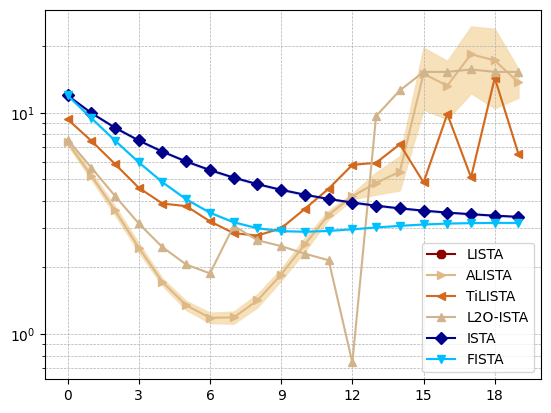

In [79]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.1)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.2)
plt.plot(np.mean(L2O_ISTA_LOSS, axis = 0), label='L2O-ISTA', color='tan', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) - (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) + (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    color='moccasin', 
                    alpha=0.2)
plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.yscale('log')

### 30db gain 

In [47]:
M = 50
LAYERS = 16
BETA_INIT = 0.4
EPOCHS = 50
SNR = 1000

LISTA_LOSS = np.zeros((M, LAYERS))
ALISTA_LOSS = np.zeros((M, LAYERS))
TiLISTA_LOSS = np.zeros((M, LAYERS))
L2O_ISTA_LOSS = np.zeros((M, LAYERS))
ISTA_LOSS = np.zeros((M, LAYERS))
FISTA_LOSS = np.zeros((M, LAYERS))

for m in tqdm(range(M)):
    # Dimensions for the signal, its sparsity and its observation

    n_ = 500
    m_ = 250
    p_ = 0.1

    # Sensing matrix

    A_ = torch.normal(0, torch.sqrt(torch.tensor(1/m_)), size = (m_, n_))
    A_ /= torch.linalg.norm(A_, dim = 0)

    # Building a training set and a test set 
    train_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 4000
        ).set_loader()

    test_set = SyntheticSignals(
        A = A_,
        n = n_,        
        m = m_,
        p = p_,
        SNR = SNR,
        size = 1000
        ).set_loader()
    
    model1 = LISTA_Net(torch.clone(A_), BETA_INIT, LAYERS)
    train(model1, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model2 = ALISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model2, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model3 = TiLISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model3, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    model4 = L2O_ISTA(torch.clone(A_), BETA_INIT, LAYERS)
    train(model4, train_set, test_set, num_epochs = EPOCHS, verbose=False)

    LISTA_LOSS[m,:] = model1.compute_nmse_inference(test_set)
    ALISTA_LOSS[m,:] = model2.compute_nmse_inference(test_set)
    TiLISTA_LOSS[m,:] = model3.compute_nmse_inference(test_set)
    L2O_ISTA_LOSS[m,:] = model4.compute_nmse_inference(test_set)

    ISTA_LOSS[m,:] = ISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)
    FISTA_LOSS[m,:] = FISTA_BATCH(test_set, LAYERS, A_, rho = BETA_INIT)

100%|██████████| 50/50 [28:06<00:00, 33.73s/it]


In [ ]:
# Sometimes convergence is not reached in training
LISTA_LOSS = LISTA_LOSS[~np.isnan(LISTA_LOSS).any(axis=1)]
ALISTA_LOSS = ALISTA_LOSS[~np.isnan(ALISTA_LOSS).any(axis=1)]
TiLISTA_LOSS = TiLISTA_LOSS[~np.isnan(TiLISTA_LOSS).any(axis=1)]
L2O_ISTA_LOSS = L2O_ISTA_LOSS[~np.isnan(L2O_ISTA_LOSS).any(axis=1)]

In [ ]:
plt.plot(np.mean(LISTA_LOSS, axis = 0), label='LISTA', color='darkred', marker = '8')
plt.fill_between(range(LAYERS), 
                    np.mean(LISTA_LOSS, axis = 0) - (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    np.mean(LISTA_LOSS, axis = 0) + (2/np.sqrt(LISTA_LOSS.shape[1])) * np.std(LISTA_LOSS, axis = 0), 
                    color='darkred', 
                    alpha=0.1)

plt.plot(np.mean(ALISTA_LOSS, axis = 0), label='ALISTA', color='burlywood', marker = '>')
plt.fill_between(range(LAYERS), 
                    np.mean(ALISTA_LOSS, axis = 0) - (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    np.mean(ALISTA_LOSS, axis = 0) + (2/np.sqrt(ALISTA_LOSS.shape[1])) * np.std(ALISTA_LOSS, axis = 0), 
                    color='wheat', 
                    alpha=0.9)

plt.plot(np.mean(TiLISTA_LOSS, axis = 0), label='TiLISTA', color='chocolate', marker = '<')
plt.fill_between(range(LAYERS), 
                    np.mean(TiLISTA_LOSS, axis = 0) - (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    np.mean(TiLISTA_LOSS, axis = 0) + (2/np.sqrt(TiLISTA_LOSS.shape[1])) * np.std(TiLISTA_LOSS, axis = 0), 
                    color='sandybrown', 
                    alpha=0.2)
plt.plot(np.mean(L2O_ISTA_LOSS, axis = 0), label='L2O-ISTA', color='tan', marker = '^')
plt.fill_between(range(LAYERS), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) - (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    np.mean(L2O_ISTA_LOSS, axis = 0) + (2/np.sqrt(L2O_ISTA_LOSS.shape[1])) * np.std(L2O_ISTA_LOSS, axis = 0), 
                    color='moccasin', 
                    alpha=0.2)
plt.plot(np.mean(ISTA_LOSS, axis = 0), label='ISTA', color='darkblue', marker = 'D')
plt.fill_between(range(LAYERS), 
                np.mean(ISTA_LOSS, axis = 0) - (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                np.mean(ISTA_LOSS, axis = 0) + (2/np.sqrt(ISTA_LOSS.shape[1])) * np.std(ISTA_LOSS, axis = 0), 
                color='cornflowerblue', 
                alpha=0.2)

plt.plot(np.mean(FISTA_LOSS, axis = 0), label='FISTA', color='deepskyblue', marker = 'v')
plt.fill_between(range(LAYERS), 
                np.mean(FISTA_LOSS, axis = 0) - (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                np.mean(FISTA_LOSS, axis = 0) + (2/np.sqrt(FISTA_LOSS.shape[1])) * np.std(FISTA_LOSS, axis = 0), 
                color='skyblue', 
                alpha=0.2)

plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))

plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.legend()
plt.yscale('log')